In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import torch
import torchvision

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from moe_models import moe_stochastic_model, moe_stochastic_loss

# Pytorch datasets

Several well known datasets are provided with the Keras implementation, and can be imported and easily used.

The MNIST dataset is a famous and has been used as a testbed of machine learning algorithms for more than 25 years. 

Look at the torchvision documentation [here](https://pytorch.org/docs/stable/torchvision/index.html) to find out about other datasets included with Keras.  There is an interesting dataset called Fashion-MNIST which is a plug-in replacement for the MNIST dataset, but which may have very different properties (it is grey-scale images). 

In [5]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [6]:
def fmnist_target_transform(target):
    return target+10

In [7]:
# datasets
trainset_mnist = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset_mnist = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

trainset_fmnist = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform,
    target_transform=fmnist_target_transform)
testset_fmnist = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform,
    target_transform=fmnist_target_transform)

trainset = torch.utils.data.ConcatDataset([trainset_mnist, trainset_fmnist])
testset = torch.utils.data.ConcatDataset([testset_mnist, testset_fmnist])


bs = 64
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                        shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=20000,
                                        shuffle=False)

# imade size and number of images
image, label = trainset.__getitem__(0)
print(image.shape, len(trainset))

torch.Size([1, 28, 28]) 120000


In [7]:
trainset_fmnist = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset_fmnist = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

bs = 64
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset_fmnist, batch_size=bs,
                                        shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_fmnist, batch_size=10000,
                                        shuffle=False, num_workers=2)

# image size and number of images
image, label = trainset_fmnist.__getitem__(0)
print(image.shape, len(trainset_fmnist))

torch.Size([1, 28, 28]) 60000


In [9]:
trainset_mnist = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset_mnist = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

bs = 64
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset_mnist, batch_size=bs,
                                        shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_mnist, batch_size=10000,
                                        shuffle=False, num_workers=2)

# image size and number of images
image, label = trainset_mnist.__getitem__(0)
print(image.shape, len(trainset_mnist))

torch.Size([1, 28, 28]) 60000


In [8]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Labels: tensor([1, 4, 0, 6, 2, 5, 8, 5, 8, 0, 8, 7, 0, 2, 6, 2, 8, 9, 9, 3, 7, 6, 7, 0,
        5, 9, 6, 7, 7, 1, 2, 7, 4, 5, 7, 8, 5, 8, 4, 2, 5, 5, 7, 7, 1, 5, 4, 1,
        5, 5, 5, 5, 7, 2, 6, 1, 3, 4, 1, 1, 6, 0, 0, 9])


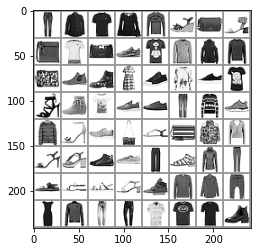

In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('Labels:', labels)
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
imshow(img_grid, one_channel=True)


Classifying these isn't easy: look how different the 4s are from each other, and the 5s. 

Take a moment to look at the images carefully: what do you think are the difficulties of classifying these with a neural net?  How large are the features that you would need to use? 

# Neural network models for MNIST classification

It is best not to use the entire MNIST dataset as a training set because you will be training for the whole of the practical class. You will learn much more by training repeatedly on smaller subsets, and examining the effect of using different models and parameters. 

In [10]:
class ExpertModel(nn.Module):
    def __init__(self):
        super(ExpertModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2,2) 
        self.fc1 = nn.Linear(32*12*12, 100) # this is a pure linear transform
        self.fc2 = nn.Linear(100, 100) # this is a pure linear transform
        self.fc3 = nn.Linear(100, 100) # this is a pure linear transform
        self.fc4 = nn.Linear(100, 100) # this is a pure linear transform
        self.fc5 = nn.Linear(100, 100) # this is a pure linear transform
        self.fc6 = nn.Linear(100, 10) # this is a pure linear transform
        self.bn = nn.BatchNorm1d(100)   
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
#         print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = x.view(-1, 32*12*12)
#         print(x.shape)
        x = F.relu(self.bn(self.fc1(x)))
        x = F.relu(self.bn(self.fc2(x)))
        x = F.relu(self.bn(self.fc3(x)))
        x = F.relu(self.bn(self.fc4(x)))
        x = F.relu(self.fc5(x))
        x = F.softmax(self.fc6(x), dim=1)
        
        return x

In [11]:
class GateModel(nn.Module):
    def __init__(self, num_experts):
        super(GateModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2,2) 
        self.fc1 = nn.Linear(32*12*12, 100) # this is a pure linear transform
        self.fc2 = nn.Linear(100, 100) # this is a pure linear transform
        self.fc3 = nn.Linear(100, 100) # this is a pure linear transform
        self.fc4 = nn.Linear(100, 100) # this is a pure linear transform
        self.fc5 = nn.Linear(100, 100) # this is a pure linear transform
        self.fc6 = nn.Linear(100, num_experts) # this is a pure linear transform
        self.bn = nn.BatchNorm1d(100)   
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*12*12)
        x = F.relu(self.bn(self.fc1(x)))
        x = F.relu(self.bn(self.fc2(x)))
        x = F.relu(self.bn(self.fc3(x)))
        x = F.relu(self.bn(self.fc4(x)))
        x = F.relu(self.fc5(x))
        x = F.softmax(self.fc6(x), dim=1)
        
        return x

In [12]:
# create a set of experts
def experts(num_experts):
    models = []
    for i in range(num_experts):
        models.append(ExpertModel())
    return nn.ModuleList(models)

In [13]:
# compute
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [14]:
# experiment with models with different number of experts
models = {}
total_experts = 2
history = []
for num_experts in range(2, total_experts+1):
    print('Number of experts ', num_experts)
    expert_models = experts(num_experts)
    gate_model = GateModel(num_experts)
    moe_model = moe_stochastic_model(num_experts, expert_models, gate_model)
    optimizer = optim.RMSprop(moe_model.parameters(),
                              lr=0.001, momentum=0.9)
#     print(moe_model)
    hist = moe_model.train(trainloader, testloader, optimizer, moe_stochastic_loss, accuracy, epochs=10)
    history.append(hist)
    models[num_experts] = moe_model

Number of experts  2
epoch 0 training loss 1.998965762825663 , training accuracy tensor(0.4652) , test accuracy tensor(0.4985)
epoch 1 training loss 1.9339912080053072 , training accuracy tensor(0.5285) , test accuracy tensor(0.5516)


KeyboardInterrupt: 

There is controversy in the ML community over whether it is better to apply Batch Normalization between a Dense (linear transformation) layer and a non-linearity, or whether it is better to do Batch Normalization after a non-linearity.  You can easily try both with this model - just move the BatchNormalization layers after the Activation layers instead of before. 

The original inventors of batch normalization - Ioffe and Szegedy in 2015 - argued that it made more sense to put Batch Normalization after a Dense layer, because the weighted mixtures produced by the dense layer would be distributed more like normal distributions, so that normalization by zeroing the mean and variance would be more naturally to apply. But, since, others have found that Batch Normalization sometimes works better directly after a non-linearity.  
There is no consensus as to which view is better.  Which camp are you in? 

In [20]:
def predict(dataloader, model):
        
        pred_labels = []
        for i, data in enumerate(dataloader):
            inputs, labels = data

            pred_labels.append(torch.argmax(model(inputs), dim=1))
            
        return torch.stack(pred_labels)

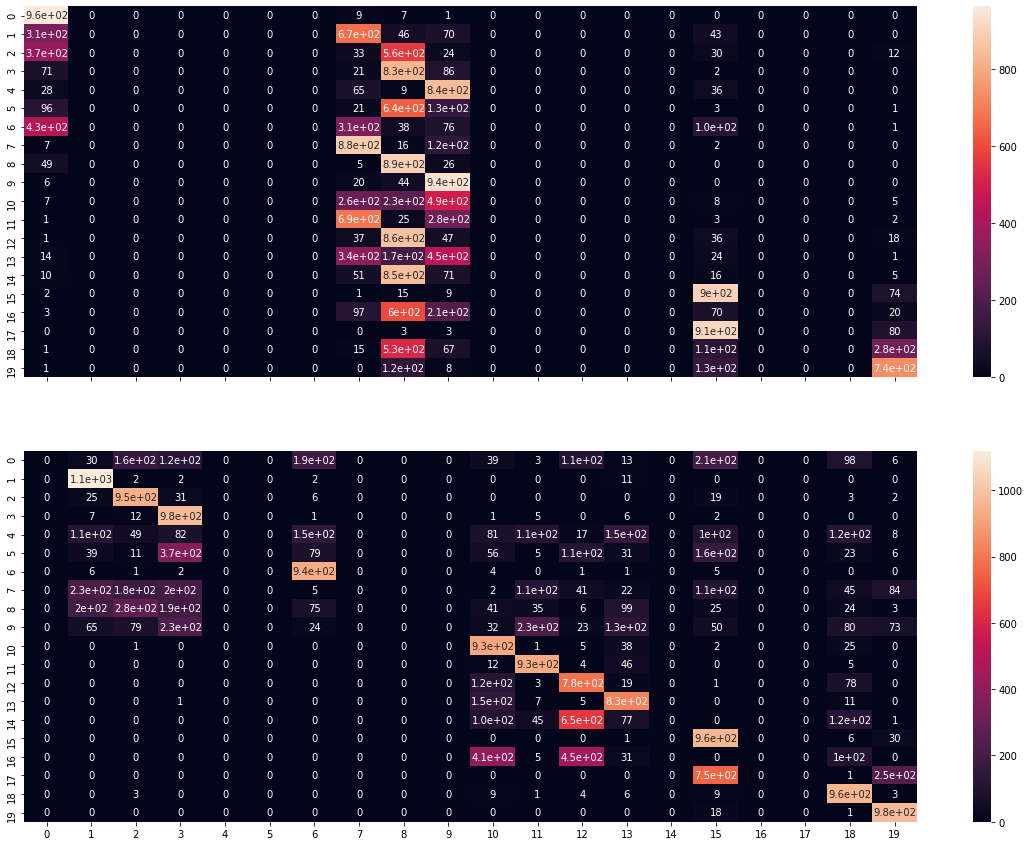

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


experts = moe_model.experts

with torch.no_grad():
    labels_1 = predict(testloader, experts[0])
    labels_2 = predict(testloader, experts[1])

    labels_np = labels.numpy()
    labels_1_np = labels_1.numpy().flatten()
    labels_2_np = labels_2.numpy().flatten()
#     print(labels_np.shape)
#     print(labels_1_np.shape)
#     print(labels_np[0:100])
#     print(labels_1_np[0:100])
#     print(labels_2_np[0:100])
#     print(confusion_matrix(labels, labels_1_np))
#     print(confusion_matrix(labels, labels_2_np))

    fig,ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20,15))
    ax = ax.flatten()
    sns.heatmap(confusion_matrix(labels, labels_1_np), annot=True, ax=ax[0])
    sns.heatmap(confusion_matrix(labels, labels_2_np), annot=True, ax=ax[1])
        

## Examining errors

5% errors on the test set is not good for MNIST, but remember that, for speed, we are using only 1/15th of the training data available. State-of-the-art (SOTA) results are down to less than 1% misclassified (but these are probably overfitted because so many people have studied this dataset and tried too many different methods on it!) 

It can be revealing to examine errors: we need a function to identify errors, and another to plot them. 

In [16]:
predictions = model_1(x_test)

In [17]:
predictions[:3,:]

tensor([[5.3248e-17, 9.8218e-12, 1.2474e-10, 1.5736e-08, 1.0027e-15, 1.2337e-18,
         3.7267e-23, 1.0000e+00, 5.2497e-12, 1.3831e-09],
        [8.0687e-08, 2.2104e-09, 1.0000e+00, 6.1228e-07, 1.3003e-14, 1.1567e-19,
         4.1440e-10, 3.2937e-16, 1.9583e-11, 3.5521e-19],
        [9.2008e-13, 1.0000e+00, 9.3723e-21, 4.2529e-14, 6.9508e-13, 2.5115e-13,
         2.6192e-14, 8.5952e-12, 1.6549e-14, 9.8198e-19]],
       grad_fn=<SliceBackward>)

In [39]:
predicted_classes = torch.argmax(predictions, axis=1)
print(predicted_classes)
print(y_test)

tensor([7, 2, 1,  ..., 4, 5, 6])
tensor([7, 2, 1,  ..., 4, 5, 6])


In [49]:
prediction_errors = (predicted_classes != y_test)

tensor([False, False, False])

In [45]:
torch.sum( prediction_errors)

tensor(1766)

In [46]:
error_images = x_test[ prediction_errors.type(torch.bool)]
error_images.shape

torch.Size([1766, 1, 28, 28])

In [50]:
error_labels = predicted_classes[ prediction_errors.type(torch.bool)]
error_labels.shape

torch.Size([1766])

tensor([4, 3, 7, 1, 9, 1, 7, 9, 4, 3, 3, 4, 2, 5, 3, 5, 5, 1, 3, 1, 4, 3, 3, 3,
        3, 1, 5, 1, 1, 2, 9, 5])


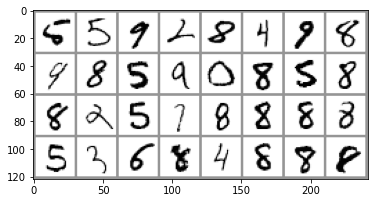

In [51]:
# create grid of images
img_grid = torchvision.utils.make_grid(error_images[0:32])
imshow( img_grid, True)
print(error_labels[0:32])

Are these numbers badly drawn?  Are there plausible reasons why they have been misclassified? What are some different reasons?  (There are several different types of reason - this is typical of real problems with large datasets.) 

*Self help*: Modify the `plot_images` statement above to give the images titles with the true classification and the (wrong) predicted classification.